# Hybrid Time-Series Forecasting (Prophet + ARIMA)

This notebook implements a hybrid forecasting approach:
1. **Prophet**: Captures trend and seasonality.
2. **ARIMA**: Models the residuals (errors) from Prophet to capture remaining autocorrelation.
3. **Hybrid**: Combines `Prophet_Prediction + ARIMA_Residual_Prediction` for the final forecast.

**Libraries**:
- `prophet`: Facebook's forecasting tool.
- `statsmodels`: For ARIMA/SARIMA and diagnostics.

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
from pathlib import Path
from prophet import Prophet
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Add project root to path
project_root = Path('../../').resolve()
sys.path.append(str(project_root))

# Set style
plt.style.use('seaborn-v0_8-darkgrid')

## 1. Load Data

In [6]:
data_path = project_root / 'data' / 'BTCUSDT_2021_2023_1m.csv'
print(f"Loading data from {data_path}...")
df = pd.read_csv(data_path)
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.set_index('timestamp').sort_index()

# Resample to hourly for forecasting (Prophet works best with hourly/daily)
df_hourly = df.resample('1H').agg({'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last', 'Volume': 'sum'})
df_hourly = df_hourly.dropna()

print(f"Data Shape (Hourly): {df_hourly.shape}")
print(df_hourly.head())

Loading data from E:\Coding\Crypto_Research\data\BTCUSDT_2021_2023_1m.csv...
Data Shape (Hourly): (26167, 5)
                         Open      High       Low     Close       Volume
timestamp                                                               
2021-01-01 00:00:00  28923.63  29031.34  28690.17  28995.13  2311.811445
2021-01-01 01:00:00  28995.13  29470.00  28960.35  29409.99  5403.068471
2021-01-01 02:00:00  29410.00  29465.26  29120.03  29194.65  2384.231560
2021-01-01 03:00:00  29195.25  29367.00  29150.02  29278.40  1461.345077
2021-01-01 04:00:00  29278.41  29395.00  29029.40  29220.31  2038.046803


C:\Users\watte\AppData\Local\Temp\ipykernel_32592\1701238684.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_hourly = df.resample('1H').agg({'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last', 'Volume': 'sum'})


## 2. Prophet Model (Trend + Seasonality)

Train Size: 25999, Test Size: 168


17:03:11 - cmdstanpy - INFO - Chain [1] start processing
17:03:27 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\watte\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(


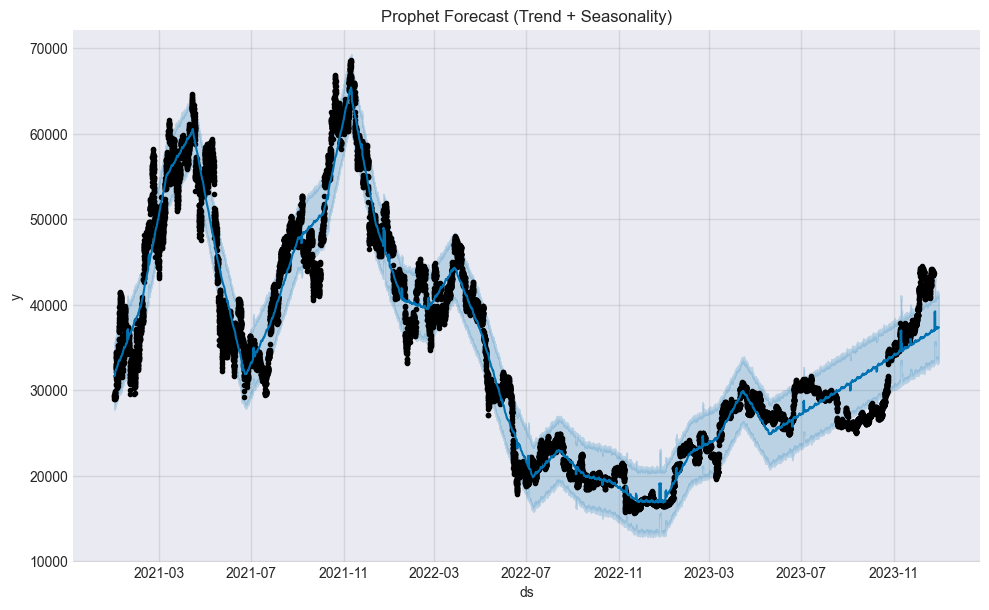

In [7]:
# Prepare data for Prophet (ds, y)
df_prophet = df_hourly.reset_index()[['timestamp', 'Close']].rename(columns={'timestamp': 'ds', 'Close': 'y'})

# Split Train/Test (Last 7 days for testing)
test_days = 7
train_size = len(df_prophet) - (test_days * 24)
train_df = df_prophet.iloc[:train_size]
test_df = df_prophet.iloc[train_size:]

print(f"Train Size: {len(train_df)}, Test Size: {len(test_df)}")

# Initialize and Train Prophet
model_prophet = Prophet(daily_seasonality=True, yearly_seasonality=False, weekly_seasonality=True)
model_prophet.add_country_holidays(country_name='US') # Optional: Add holidays
model_prophet.fit(train_df)

# Forecast
future = model_prophet.make_future_dataframe(periods=len(test_df), freq='H')
forecast = model_prophet.predict(future)

# Extract predictions for test set
prophet_pred = forecast.iloc[train_size:]['yhat'].values
prophet_residuals = train_df['y'] - forecast.iloc[:train_size]['yhat']

# Plot Prophet Results
fig1 = model_prophet.plot(forecast)
plt.title('Prophet Forecast (Trend + Seasonality)')
plt.show()

## 3. ARIMA Model (Residuals)

Training ARIMA on residuals...


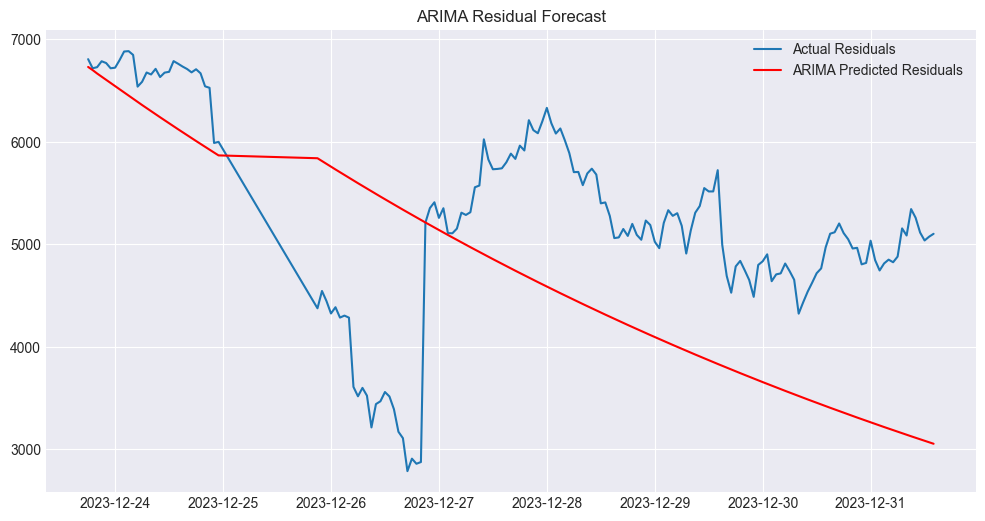

In [8]:
# Fit ARIMA on Prophet Residuals
# Order (p,d,q) needs tuning, using (5,0,1) as a starting point for hourly data
print("Training ARIMA on residuals...")
model_arima = ARIMA(prophet_residuals, order=(5,0,1))
model_arima_fit = model_arima.fit()

# Forecast Residuals
arima_pred = model_arima_fit.forecast(steps=len(test_df))

# Plot Residual Forecast
plt.figure(figsize=(12, 6))
plt.plot(test_df['ds'], test_df['y'].values - prophet_pred, label='Actual Residuals')
plt.plot(test_df['ds'], arima_pred, label='ARIMA Predicted Residuals', color='red')
plt.title('ARIMA Residual Forecast')
plt.legend()
plt.show()

## 4. Hybrid Forecast & Evaluation

Hybrid Model RMSE: 1306.1948
Hybrid Model MAE: 1152.7127
Prophet Only RMSE: 5354.9063


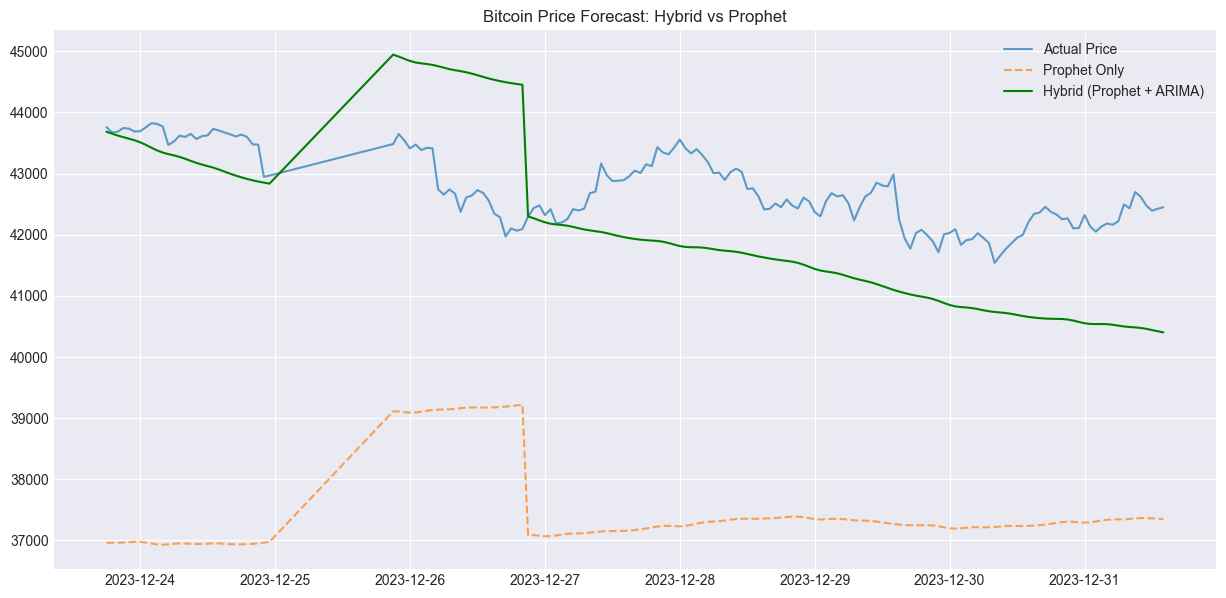

In [9]:
# Combine Predictions
final_pred = prophet_pred + arima_pred

# Evaluation
y_true = test_df['y'].values
rmse = np.sqrt(mean_squared_error(y_true, final_pred))
mae = mean_absolute_error(y_true, final_pred)

print(f"Hybrid Model RMSE: {rmse:.4f}")
print(f"Hybrid Model MAE: {mae:.4f}")

# Compare with Prophet Only
rmse_prophet = np.sqrt(mean_squared_error(y_true, prophet_pred))
print(f"Prophet Only RMSE: {rmse_prophet:.4f}")

# Visualization
plt.figure(figsize=(15, 7))
plt.plot(test_df['ds'], y_true, label='Actual Price', alpha=0.7)
plt.plot(test_df['ds'], prophet_pred, label='Prophet Only', linestyle='--', alpha=0.7)
plt.plot(test_df['ds'], final_pred, label='Hybrid (Prophet + ARIMA)', color='green')
plt.title('Bitcoin Price Forecast: Hybrid vs Prophet')
plt.legend()
plt.show()